## Understanding Employee Attrition: Identifying Trends and Reducing Turnover

## *What is Attrition?*

Employee attrition refers to the departure of an employee from a company for any reason. Involuntary attrition occurs when employees are terminated due to factors such as inadequate performance or business mandates, whereas voluntary attrition is the phenomenon of often high performing employees choosing to leave on their own volition (Alduayj & Rajpoot, 2018). Although voluntary departures can result from retirement and other personal reasons, they are frequently driven by workplace-related factors such as low job satisfaction or lack of finanacial compensation (Alduayj & Rajpoot, 2018).

High attrition rates are problematic not only because of the loss of talent and experience a seasoned employee may contribute, but also due to the emotional and financial impact on these organizations; Remaining coworkers may have lower morale leading to a less positive working environment and lower productivity (Frye et al., 2018). Additionally, the cost and time of interviewing, hiring, and training a replacement will likely be substantial (Frye et al., 2018). Therefore, understanding what leads an employee to attrit is crucial for a company to prevent these potential losses.

This study aims to answer two questions:
1) What are the factors influencing employee attrition?
2) How can predictive models created with these factors in mind be used to prevent high turnover rates?

This study utilizes a dataset which explores various factors that could influence whether an employee decides to stay with or leave a company. This dataset contains 1,470 observations and 35 factors, including information about demographics, job role, salary, satisfaction levels, and performance. The data originates from a HR analytics setting aimed at understanding employee attrition patterns.

The dataset: https://www.kaggle.com/datasets/rishikeshkonapure/hr-analytics-prediction/

In [1]:
library(tidyverse)
library(dplyr)
library(GGally)
library(reshape2)
library(glmnet)
library(tidymodels)
library(caret)
library(pROC)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


A

## HR Employee Attrition

In [2]:
hr_attrition <- read_csv("data/HR-Employee-Attrition.csv")
head(hr_attrition)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


The response variable of this dataset `Attrition` is a binary variable indicating whether or not an employee has "attrited" or not where
$$
f(x) =
\begin{cases}
1 \; \; \; \; \mbox{if the employee has left the company}\\
0 \; \; \; \; 	\mbox{otherwise}
\end{cases}
$$

The input variables are categorized as follows:

**Demographic Information**
- `Age`: Age in years
- `Gender`: Gender of the employee (Male/Female)
- `MaritalStatus`: Relationship Status of employee with 3 levels (Married, Single, other)
- `Over18`: Whether the employee is over 18 (Y/N)
- `EmployeeNumber`: A unique combination of 4 digits assigned to every employee
- `Education`: A numerical representation of level of education: 1-"below college", 2-"college", 3-"bachelors", 4-"masters", 5-"doctor"
- `EducationField`: Stream of education of employee (Life sciences, Medical, Human resources, Marketing, Technical degree, other)
- `EmployeeCount`: Employee count (constant, 1)

**Work Environment**

- `BusinessTravel`: How frequently the employee travels for work with 3 levels (Rarely, Frequently, none)
- `Department`: Department of an employee (Research & Development, Sales, Human resources)
- `JobInvolvement`: Level of involvement of employee with 1 being low, 4 being the highest involvement
- `JobLevel`: Level of job of employee between 1-5
- `JobRole`: Role of employee (Sales executive, Healthcare representative, Human resources, Laboratory Technician, Manager, Manufacturing director, Research director, Research scientist, Sales representative)
- `JobSatisfaction`: How satisfied employee is with job where 1 is low satisfaction and 4 is highest
- `PerformanceRating`: Rating given to employee based on performance (3/4)
- `TotalWorkingYears`: Total years employee spent working 
- `YearsAtCompany`: Total years employee spent working at this company
- `YearsInCurrentRole`: Number of years spent at current role 
- `YearsSinceLastPromotion`: Number of years since employee was last promoted
- `YearsWithCurrManager`: Number of years spend working under current manager 
- `NumCompaniesWorked`: Number of companies the employee has worked for
- `RelationshipSatisfaction`: Level of satisfaction working with other colleauges between 1-4
- `EnvironmentSatisfaction`: Level of satisfaction with working environment between 1-4

**Financial Compensation**
- `DailyRate`: Daily wage of an employee in dollars 
- `MonthlyIncome`: Monthly income of employee in dollars
- `MonthlyRate`: Monthly fixed rate of employee in dollars
- `OverTime`: Binary representation of whether the employee works overtime (Yes/No)
- `PercentSalaryHike`: Percentage of salary increase while employed 
- `StockOptionLevel`: Level of stock options granted to employee between 0-3

**Work-life Balance** 
- `DistanceFromHome`: Distance from home to office in kilometers
- `WorkLifeBalance`: Level of work-life balanced achieved between 1-4
- `TrainingTimesLastYear`: Number of hours employee spent in training sessions in the previous year
- `StandardHours` : Number of hours worked per week 

## Motivation

*How do factors such as the number of years employed at a company, job satisfaction, and monthly income influence employee attrition?*

The number of years employed at a company and monthly income are continuous variables which we can use by analyzing the summary statistics for each level of attrition (yes/no). Comparing the spread of the distributions would help indicate whether there is a statistically significant relationship between the difference in employees who leave and stay vs. how long they are employed at the company or their monthly income. Job satisfaction is a categorical variable with 4 levels, which we can use to see if there is higher attrition in employees who are less satisfied with their jobs. After understanding the relationship between variables we can predict employee attrition using a classifier model. Therefore this analysis will focus on both inference and prediction. 

This combination of variables in particular is of interest to me as there are many different ways to possibly interpret the relationship between them and the response, as well as how they impact eachother. For example, one would expect an employee with low job satisfaction to attrit, but if that same employee had worked for the company for many years, then they might feel loyalty towards the company. At the same time, this would probably change depending on that same employee's monthly income—perhaps someone with a higher monthly income would stay for the benifits, while an employee who has been working for a company for a long time yet still has a relatively low monthly income would be more likely to attrit. Obviously this prompts heavy evaluation of the variables in order to combat multicollinearity and the consideration of potential interaction terms.

In [3]:
hr_attrition <- na.omit(hr_attrition)
hr_attrition <- hr_attrition %>% 
            dplyr::select(EmployeeNumber, 
                          Attrition, 
                   YearsAtCompany,
                   JobSatisfaction,
                   MonthlyIncome) %>%
            mutate(Attrition = if_else(Attrition == "Yes", 1, 0))

hr_attrition$Attrition <- factor(hr_attrition$Attrition, levels = c(0, 1), labels = c("No", "Yes"))
hr_attrition$JobSatisfaction <- factor(hr_attrition$JobSatisfaction)

head(hr_attrition)

EmployeeNumber,Attrition,YearsAtCompany,JobSatisfaction,MonthlyIncome
<dbl>,<fct>,<dbl>,<fct>,<dbl>
1,Yes,6,4,5993
2,No,10,2,5130
4,Yes,0,3,2090
5,No,8,3,2909
7,No,2,2,3468
8,No,7,4,3068


First, in order to evaluate the prescence of multicollinearity, we can look at the relationships between each input variable:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


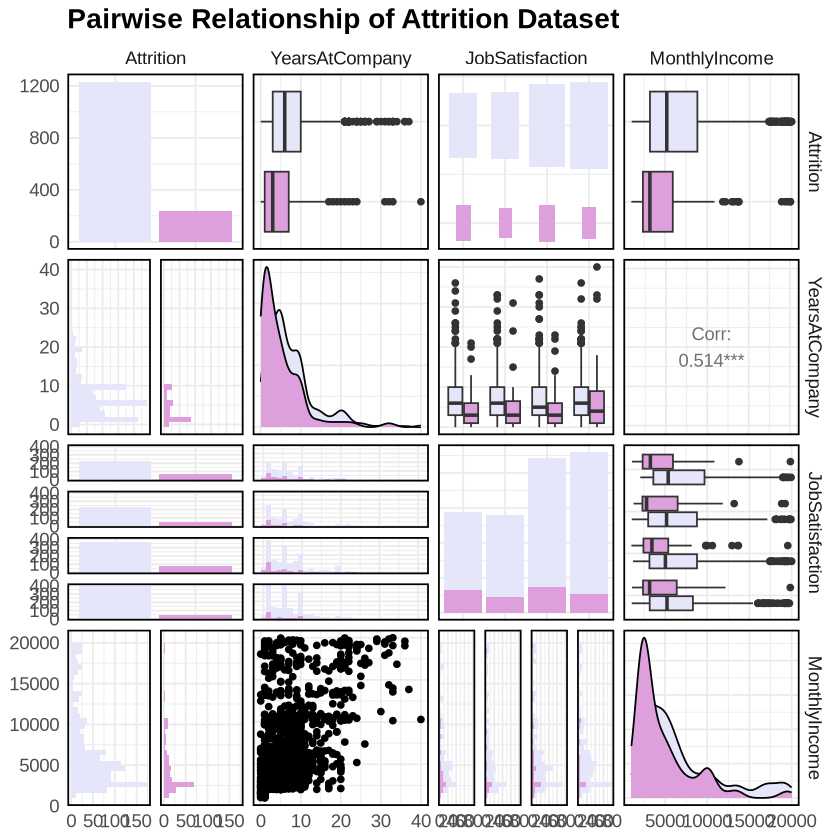

In [4]:
hr_attrition_subset <- hr_attrition %>% 
            dplyr::select(Attrition, 
                           YearsAtCompany,
                           JobSatisfaction,
                           MonthlyIncome)

hr_attrition_pair_plots <- hr_attrition_subset %>%
    ggpairs(progress = FALSE, mapping = aes(fill = Attrition)) + 
        scale_fill_manual(values = c("Yes" = "plum", "No" = "lavender")) +
        theme_minimal() +
        theme(text = element_text(size = 14),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold"), 
        panel.border = element_rect(color = "black", fill = NA, linewidth = 1)
         ) +
    ggtitle("Pairwise Relationship of Attrition Dataset")

hr_attrition_pair_plots

Based on this correlation matrix there is not much association between any of the inpute variables. Particularly, job satisfaction yields very low correlation between the other two input variables. What could be more of an issue is the relationship between years at company and monthly income which has a slightly higher coefficient of .514, meaning there is some positive relationship. Although this number is not very high so it will likely not pose much of a problem. 

The relationship between the predictors and the response are a bit more telling. Between years at company and attrition, it does seem as though generally, the longer an employee works the less likely they are to attrit. However, it is important to note that attrition can include retirement which may explain some outliers. Between monthly income and attrition there does seem to also be a relationship as a greater proportion of high income employees are less likely to attrit. There is noticeably many high income employees who did attrit, but again, this could potentially be explained by the fact that retirement counts as attrition and thus creates outliers. Lastly, the relationship between job satisfaction and attrition exists as well as the range of those who do not attrit is much higher than the range of those who do. Something that is interesting though is that the median ranking of job satisfaction is the same between those who do and do not attrit. This is likely due to the fact that there just are not as many people who attrit compared to those who do. 

This feature brings up an important consideration for this entire process: since the attrition variable is so unbalanced with a large proportion being "No," this can lead to bias when creating the model. Thus, a classifier may predict "No" for many cases, which may be highly accurate, but not very sensitive. In other words, it will cause an underfitting of the "Yes" level and fail to capture important feautures of employees who attrit. 

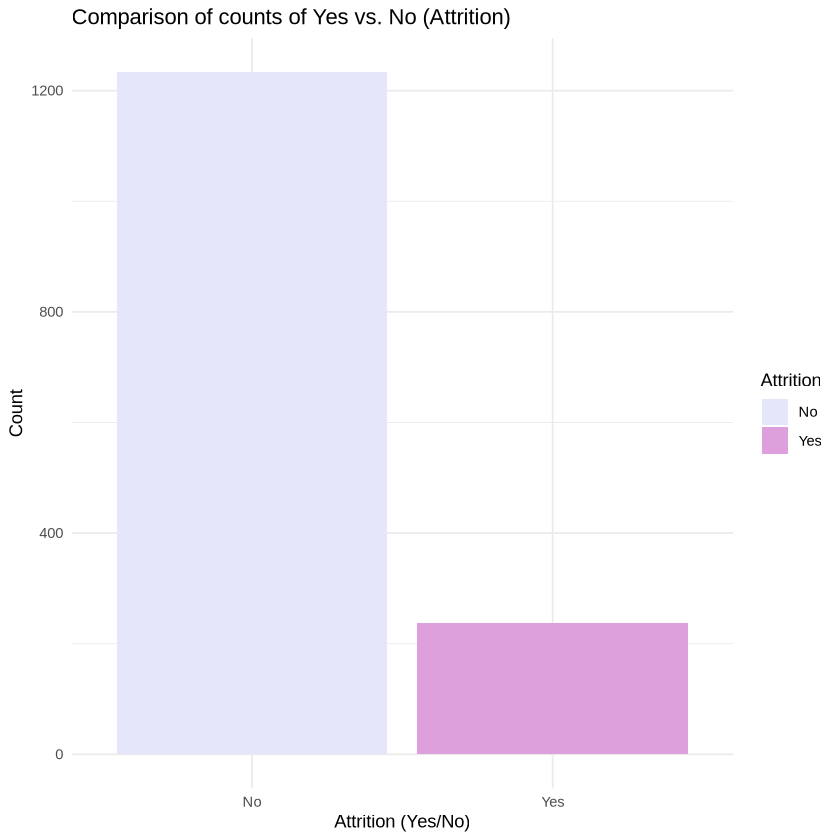

In [29]:
# counts of employees who attrit and do not
no_count <- sum(hr_attrition$Attrition == "No") 
yes_count <- sum(hr_attrition$Attrition == "Yes")

imbalance <- hr_attrition %>% 
    ggplot(aes(x = Attrition, fill = Attrition)) +
    geom_bar() + 
    ggtitle("Comparison of counts of Yes vs. No (Attrition)") + 
    xlab("Attrition (Yes/No)") + 
    ylab("Count") + 
    theme(plot.title = element_text(face = "bold", hjust = .5, size = 20), 
          axis.title = element_text(face = "bold", size = 10), 
          panel.border = element_rect(color = "black", fill = NA, linewidth = 1)) + 
    theme_minimal() + 
    scale_fill_manual(values = c("Yes" = "plum", "No" = "lavender"))
imbalance

A closer look at the top left plot of the counts of attrition from the pairwise plot reveals that the proportion of employees who attrit vs those who do not is very low. This issue can be addressed in the future via representing true/false positive/negatives in a confusion matrix to understand model performance and enhance it if needed. Additionally, the data can be stratified when conducting cross validation (rather than random sampling) in order to ensure that the proportion is maintained in both training and testing datasets. Further, we can look at specific visualizations incase the pariwise plot has any hidden information due to this imbalance: 

## A Further Look

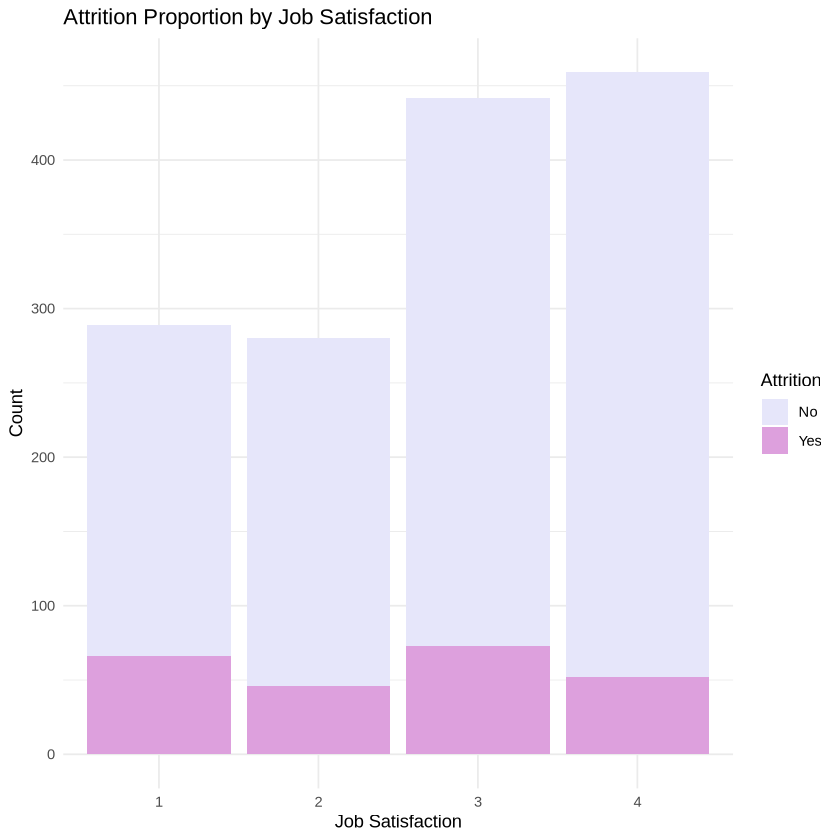

In [30]:
job_satisfaction <- hr_attrition %>%
    ggplot(aes(x = JobSatisfaction, fill = Attrition)) + 
    geom_bar() + 
    ggtitle("Attrition Proportion by Job Satisfaction") + 
    xlab("Job Satisfaction") + 
    ylab("Count") + 
    theme(plot.title = element_text(face = "bold", hjust = 0.5, size = 20), 
          axis.title = element_text(face = "bold", size = 10), 
          panel.border = element_rect(color = "black", fill = NA, linewidth = 1)) + 
    theme_minimal() + 
    scale_fill_manual(values = c("Yes" = "plum", "No" = "lavender"))
    
job_satisfaction

The only clear visualization on the pariwise plot for this relationship is through a boxplot, which is innacurate as job satisfaction is a categorical variable. On closer inspection, it seems that perhaps these two variables are not as closely related, or there is more complexity that job satisfaction alone cannot accurately portray. In the pairwise plot since there was such an imbalance it was difficult to see the disparity between those who attrit, but now it is much clearer. We observe that those who attrit do not necessarily have lower job satisfaction. However, we can also say that those with higher job satisfaction are less likely to attrit as the proportion of those who do not attrit is much higher in the upper range of job satisfaction. 
NOTE: this plot is now in the correlation matrix, it was not before because I forgot to make JobSatisfaction a categorical variable with 4 levels, which is why there was also a correlation index: It was read as continuous. 

**The Plan**

In order to fully analyze the relationship between these variables and create a preditive model, a logistic regression model may be fitted and used to predict probabilities. Then, a confusion matrix of ROC curve may be utilized to assess the strength of the model. Or, can use ridge to calculate RMSE (compare)
Things to consider: 
- Maybe test nested model including/excluding job satisfaction as it seems less correlated with the other input variables and response
- Decide whether to use interactive or additive model, would assume that factors like monthly income impact job satisfaction which impacts response, etc. (fit both models)
- Prescence of confounding variables? Employee attrition is quite general, so factors not in the data could impact other variables and the response. 

**Interactive vs. Additive Model**

In [31]:
interactive_attrition <- glm(Attrition ~ JobSatisfaction * YearsAtCompany * MonthlyIncome, 
                         family = binomial, 
                         data = hr_attrition)
tidy(interactive_attrition)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.655126e-01,3.763350e-01,0.7055218,0.48048555
JobSatisfaction2,-2.660390e-01,5.494155e-01,-0.4842218,0.62822846
JobSatisfaction3,-3.720381e-01,5.005778e-01,-0.7432173,0.45735012
JobSatisfaction4,-8.251071e-01,5.397886e-01,-1.5285745,0.12636996
YearsAtCompany,-1.570494e-01,6.118261e-02,-2.5668954,0.01026136
MonthlyIncome,-1.615777e-04,6.050792e-05,-2.6703567,0.00757707
JobSatisfaction2:YearsAtCompany,-7.160800e-02,9.531032e-02,-0.7513143,0.45246355
JobSatisfaction3:YearsAtCompany,-2.041396e-02,8.215391e-02,-0.2484843,0.80375973
JobSatisfaction4:YearsAtCompany,6.872471e-02,7.962082e-02,0.8631500,0.38805501


Based on most of the p-values for the interactive model being quite high we may proceed with the additive model. 

## Individual Assignment 2

## Methods and Planning ##

A logistic model will be fitted in order to investigate the relationship between number of years employed at a company, job satisfaction, and monthly income on the prevelance of employee attrition. This is the most appropriate method due to the fact that the response variable has a binary outcome ie. employee attrition is measured by either "yes" or "no." This means that if we were to try and use, say, a linear model, the range of the prediction would not be valid since the outcome of predicting attrition is a probability curve between 0 and 1, rather than some continuous value on a straight line. In this case, the additive logistic regression model can be fitted as follows: 
$$
\begin{equation*} 
\mbox{logit}(p_i) = \log\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1\text{Years} + \beta_2\text{Income} + \beta_3\text{JobSatisfaction}_2 + \beta_4\text{JobSatisfaction}_3 + \beta_5\text{JobSatisfaction}_4
\end{equation*}
$$

Where $\log\left(\frac{p_i}{1 - p_i}\right)$ is the logarithm of the odds, or the ratio of the probability of success (${p_i}$) to the probability of failure (${1 - p_i}$). In this specific case, the odds are how likely an employee is to attrit compared to how unlikely it is at fixed values of the covariates. The coefficients can then be interpreted as the change in the log odds of the event as the respective variable increases by one unit, while holding the other predictors constant. The intercept $\beta_0$ is the log odds of attrition when the continuous variables are 0, and the job satisfaction dummy variable is at its reference level, 1. $\beta_1$ is then the change in log odds as years worked at company increases while the other predictors do not change, and so forth. 

Since the log odds of an event may be difficult to interpret in real situations, the exponent of the log odd coefficients can be taken to get the odds ratio, which tells us how the predictor impacts the odds of the event; If the odds ratio is greater than 1, then it will increase the odds, and if it is less than 1, it will decrease the odds. This is another reason as to why logistic regression is applicable to this dataset: it makes interpreting the odds of attrition simple, in addition to explaining how a change in certain predictors will impact the likelihood of attrition. A logistic regression model is also apropriate as we can evaluate the fit of the model using various methods such as comparing the full model to a nested one, or creating an ROC curve to understand how well the model classifies employees across different threshold values. 

Some assumptions of a logistic regression model include the fact that the observations are independent of eachother, the log odd ratios are linearly related to the predictors, and that there is not much multicollinearity. We can say that some of these assumptions are met as the employees are not grouped in any particular way to indicate that their responses may impact eachother. Additionally, we have already checked for multicollinearity of the predictors and concluded through a lack of visual evidence that there is not much to be worried about. However, as seen in the plot comparing the amount of attrition vs retention, it is evident that the rate of attrition is much lower than the rate of retention, meaning this data is not well balanced. This can lead to low precision in the predicted rate of attrition on new data as the model will likely be very accurate in classifying retention but not so much in attrition

## Implementation of a Proposed Model ##

In [31]:
attrition_model <- glm(Attrition ~ JobSatisfaction + YearsAtCompany + MonthlyIncome, 
                         family = binomial, 
                         data = hr_attrition)

attrition_model_results <- attrition_model %>%
    tidy() %>%
    mutate(exp_est = exp(estimate)) #log odd ratios 

attrition_model_results

term,estimate,std.error,statistic,p.value,exp_est
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.396546e-01,1.889951e-01,-1.797161,7.231014e-02,0.7120162
JobSatisfaction2,-4.366186e-01,2.180629e-01,-2.002259,4.525685e-02,0.6462179
JobSatisfaction3,-4.338911e-01,1.938072e-01,-2.238777,2.517046e-02,0.6479828
JobSatisfaction4,-8.693468e-01,2.067894e-01,-4.204020,2.622157e-05,0.4192253
YearsAtCompany,-4.808058e-02,1.793033e-02,-2.681523,7.328795e-03,0.9530570
MonthlyIncome,-9.935809e-05,2.341645e-05,-4.243090,2.204634e-05,0.9999006


In [27]:
#Comparing the full logistic model to a reduced model 
reduced_attrition_model <- glm(Attrition ~ JobSatisfaction, 
                         family = binomial, 
                         data = hr_attrition)
anova(reduced_attrition_model, attrition_model, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1466,1281.226,NA,NA,NA
2,1464,1227.327,2,53.89896,1.976923e-12


From the full logistic model we can see that all of the predictors are statistically significant as they are smaller than a significance level of 5%. However, since there are many predictors, it is worth checking if a simpler model fits better. I noted that the job satisfaction variable has the greatest impact on the odds of attrition as the exponentiated estimates show the greatest decreases: as job satisfaction increases to 2 from 1, the odds of attrition decrease by 35.3%, and eventually jumps to a 58.1% decrease as job satisfaction is at the highest level. However, from the chi-squared test, this is not the case and the full model including all of the predictors is more appropriate. Now we can evaluate the predictive performance of this model: 

In [28]:
#make training and testing datat for attrition + predictors
attrition_train <- hr_attrition %>%
    slice_sample(prop = .70)

#antijoin using employee number so employees dont get reused 
attrition_test <- hr_attrition %>%
    anti_join(attrition_train, by = "EmployeeNumber")

attrition_train <- 
    attrition_train %>% 
    dplyr::select(-EmployeeNumber)

attrition_test <- 
    attrition_test %>% 
    dplyr::select(-EmployeeNumber)

#Make a new regression model using the TRAINING data
attrition_logistic_model <- glm(Attrition ~ ., 
                         family = binomial, 
                         data = attrition_train)
tidy(attrition_logistic_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.2471142532,2.193216e-01,-1.126721,0.2598604211
YearsAtCompany,-0.0421730294,2.029196e-02,-2.078312,0.0376806378
JobSatisfaction2,-0.6918692968,2.631021e-01,-2.629661,0.0085470134
JobSatisfaction3,-0.5589279929,2.293811e-01,-2.436679,0.0148228431
JobSatisfaction4,-0.7438567627,2.319601e-01,-3.206830,0.0013420628
MonthlyIncome,-0.0001011254,2.677346e-05,-3.777075,0.0001586812


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6778

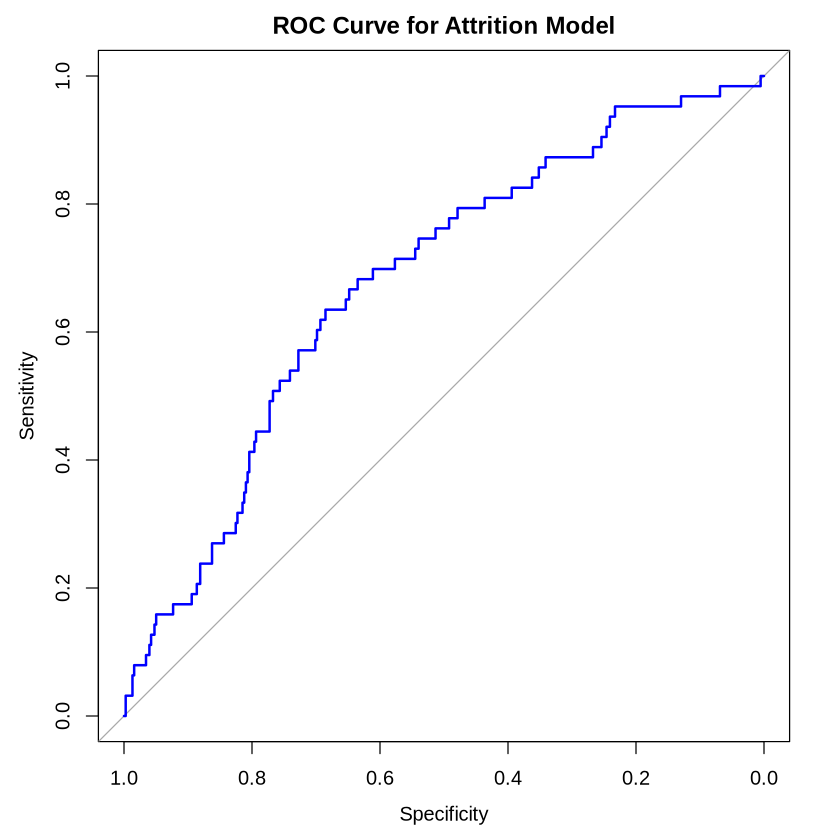

In [29]:
#predict performance of logistic model on new data
predict <- predict(attrition_logistic_model, newdata = attrition_test, type = "response")
attrition_test$Attrition_binary <- if_else(attrition_test$Attrition == "Yes", 1, 0)

#create ROC curve and get AUC 
roc_curve <- roc(attrition_test$Attrition_binary, predict)
plot(roc_curve, col = "blue", main = "ROC Curve for Attrition Model")
auc_value <- auc(roc_curve)
auc_value

An roc curve was modelled using a basic logistic regression model. The area under the curve is found to be .68 which is not very high and indicates that the model is only slightly better than pure random guessing. Between the previous table comparing the nested models which showed that the predictors are statistically significant and this plot, there seems to be a discrepency in the significance of the predictors and the overall predictive performance of the model. This is likely due to multicollinearity, as it would inflate the individual p-values by not considering the impact of the predictors on eachother. Although I initially believed there to be no multicollinearity through the correlation matrix, this should have been corroborated through checking the variance inflation factor much earlier on in the process. Possible ways to address this issue involve modelling the roc curve using ridge or lasso cross validation in order to penalize predictors that impact the model less directly. Additionally, it is important to note that attrition being so unbalanced may have influenced the predictive capabilities of this model which can be resolved using resampling techniques. 

In [32]:
vif(attrition_model)

JobSatisfaction2 JobSatisfaction3 JobSatisfaction4   YearsAtCompany 
        10.77833         11.61016         13.49905         17.72665 
   MonthlyIncome 
        17.85372

# References

Alduayj, S. S., & Rajpoot, K. (2018, November 1). Predicting Employee Attrition using Machine Learning. IEEE Xplore. https://doi.org/10.1109/INNOVATIONS.2018.8605976

Frye, A., Boomhower, C., Smith, M., Vitovsky, L., Fabricant, S., & Mumford, D. (2018). Employee Attrition: What Makes an Employee Quit? SMU Data Science Review, 1(1), 9. https://scholar.smu.edu/cgi/viewcontent.cgi?article=1010&context=datasciencereview